In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob    
import os

In [2]:
IMAGE_DIR = "./dataset/flower_photos/"
all_images = glob.glob(IMAGE_DIR+"/*/*.jpg",recursive=True)

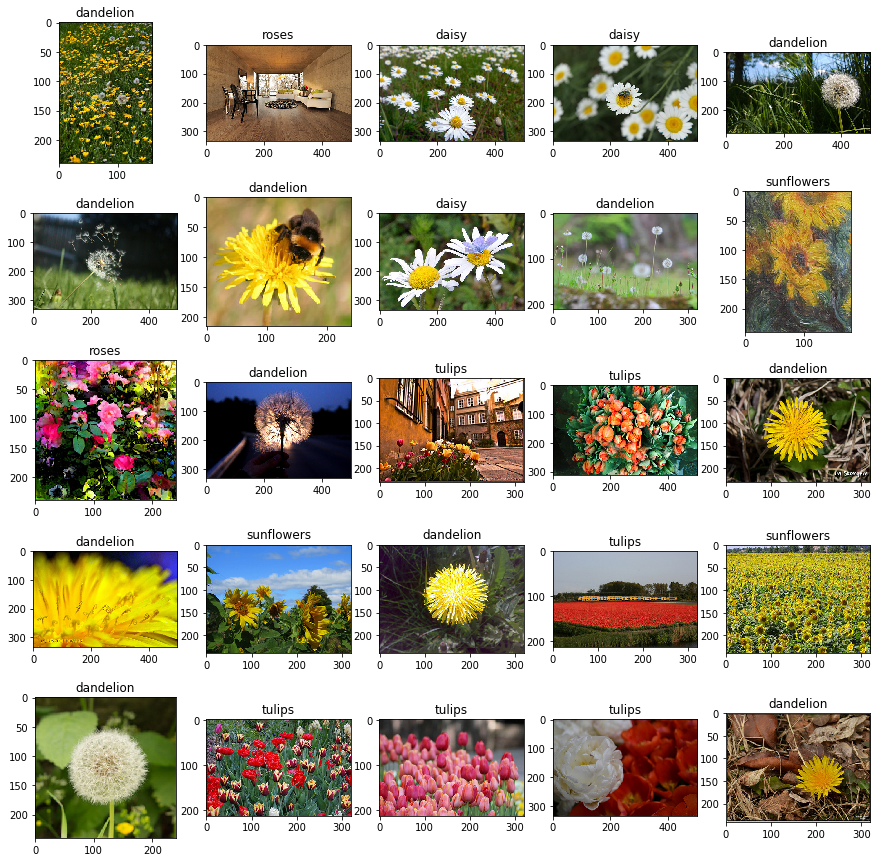

In [3]:
nsd = np.random.RandomState(2019)
test_images = nsd.choice(all_images,25,False)
plt.figure(figsize=(15,15))
for index,test_image in enumerate(test_images):
    label_name = os.path.basename(os.path.dirname(test_image))
    ax = plt.subplot(5,5,index+1)
    ax.imshow(Image.open(test_image))
    ax.set_title(label_name)
plt.show()

In [4]:
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299

with tf.python_io.TFRecordWriter("./TFTest/test.tf") as writer:
    for index,test_image in enumerate(test_images):
        image_name = os.path.basename(os.path.dirname(test_image))
        image_data = Image.open(test_image)
        if image_data.mode != 'RGB':
            image_data.convert("RGB")
        image_data = image_data.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)    
        ex = tf.train.Example(features=tf.train.Features(feature = {
            'data':tf.train.Feature(bytes_list = tf.train.BytesList(value=[image_data.tobytes()])),
            'h':tf.train.Feature(int64_list = tf.train.Int64List(value=[image_data.size[1]])),
            'w':tf.train.Feature(int64_list = tf.train.Int64List(value=[image_data.size[0]])),
            'c':tf.train.Feature(int64_list = tf.train.Int64List(value=[3])),
            'name':tf.train.Feature(bytes_list = tf.train.BytesList(value=[image_name.encode("utf-8")])),
        }))
        writer.write(ex.SerializeToString())

# 测试iter方式读取

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


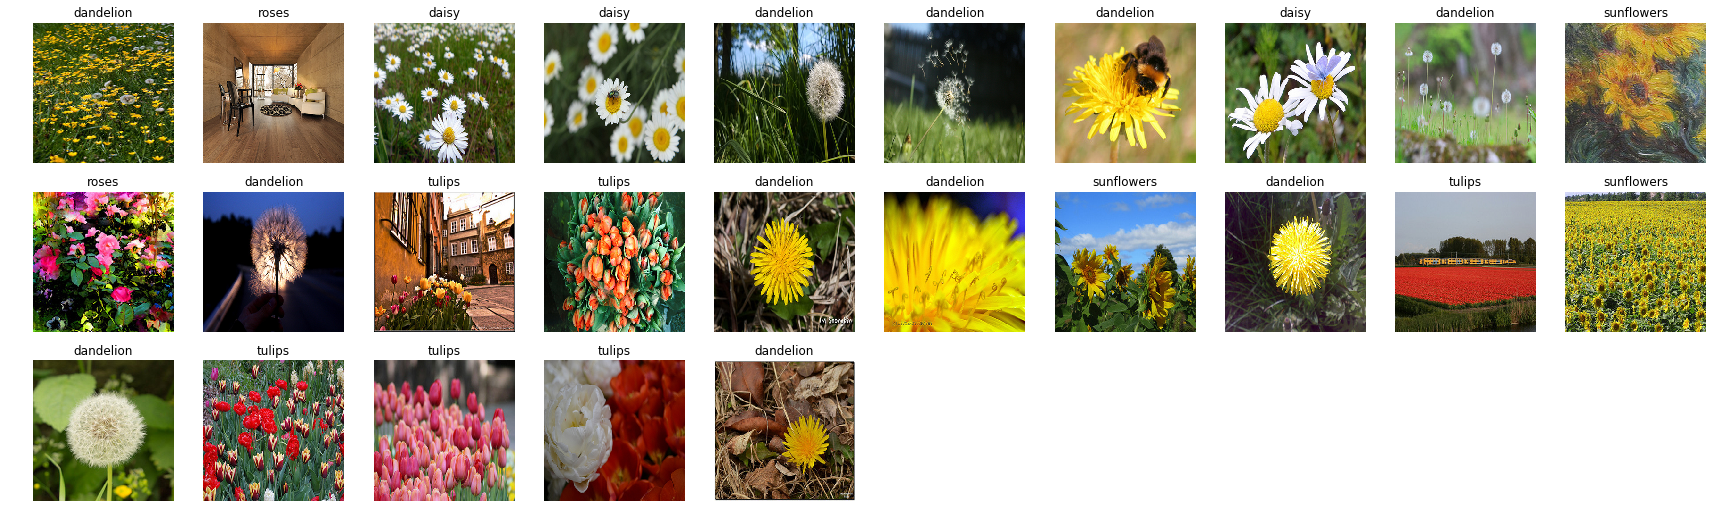

In [5]:
plt.figure(figsize=(30,15))
plt.axis("off")
datas_iter = tf.python_io.tf_record_iterator("./TFTest/test.tf")
index = 1
for data_iter in datas_iter:
    ex = tf.train.Example()
    ex.ParseFromString(data_iter)
    image_data = ex.features.feature['data'].bytes_list.value[0]
    image_weight = ex.features.feature['w'].int64_list.value[0]
    image_height = ex.features.feature['h'].int64_list.value[0]
    image_channel = ex.features.feature['c'].int64_list.value[0]
    image_name = ex.features.feature["name"].bytes_list.value[0].decode("utf-8")
    ax = plt.subplot(5,10,index)
    ax.axis("off")
    ax.set_title(image_name)
    image = Image.frombytes(mode="RGB",size=(image_weight,image_height),data=image_data)
    np_data = np.array(image)
    ax.imshow(image)
    index+=1
plt.show()

# 测试batch加载

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecor

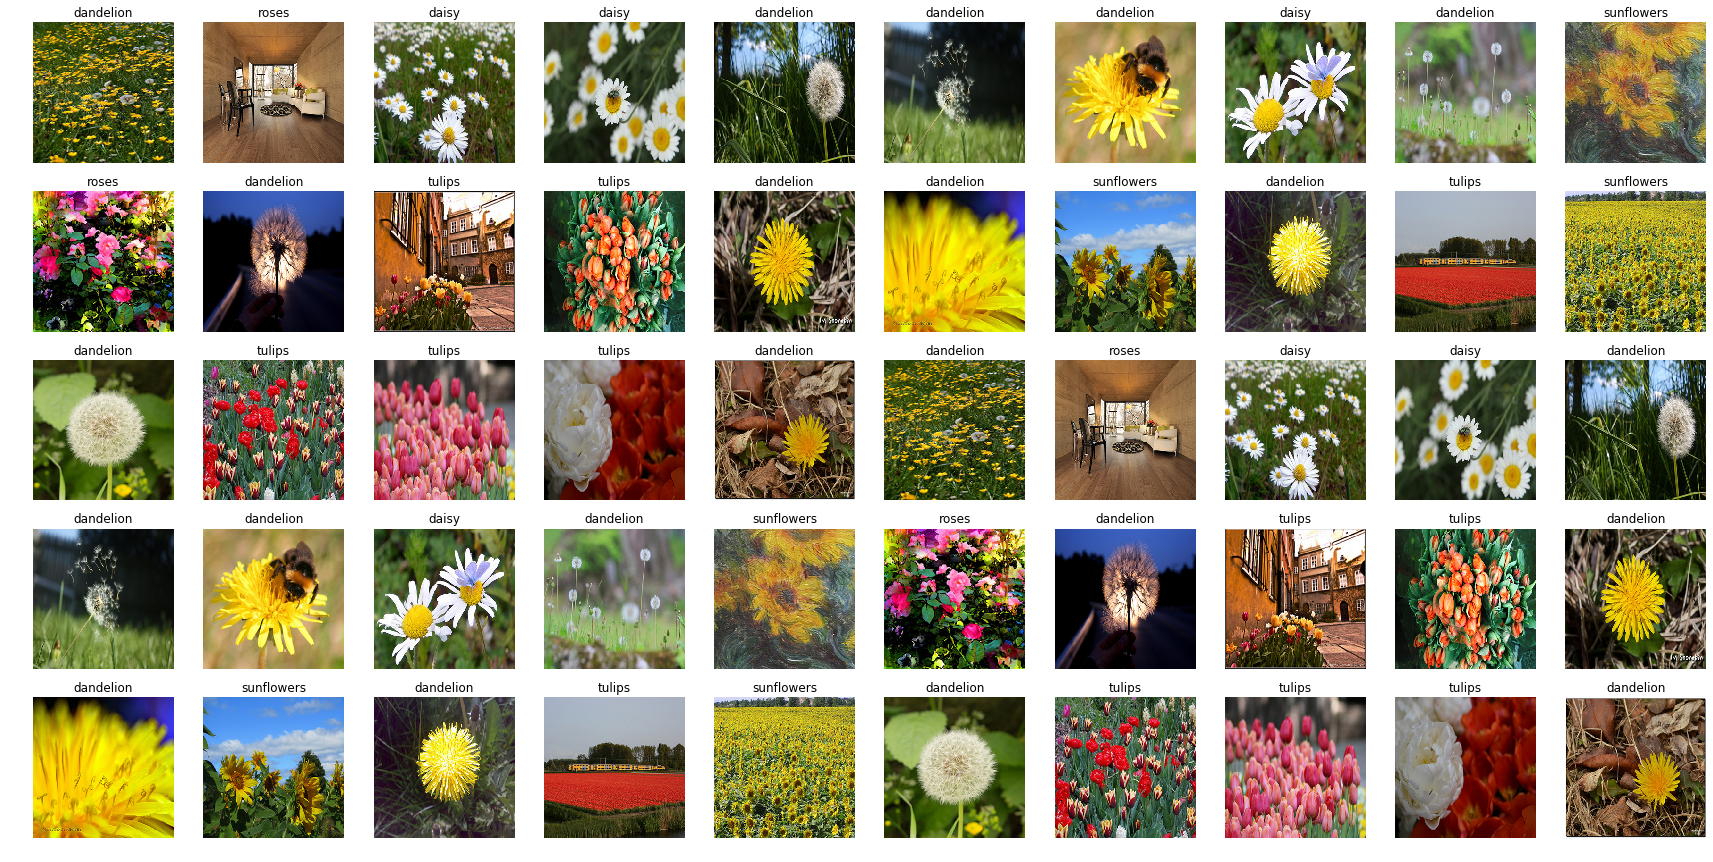

In [6]:
files_queue = tf.train.string_input_producer(["./TFTest/test.tf"])
reader = tf.TFRecordReader()
_,serialized_example = reader.read(files_queue)

feature = {
    'data':tf.FixedLenFeature([],tf.string),
    'h':tf.FixedLenFeature([],tf.int64),
    'w':tf.FixedLenFeature([],tf.int64),
    'c':tf.FixedLenFeature([],tf.int64),
    'name':tf.FixedLenFeature([],tf.string),
}

feature_tensor = tf.parse_single_example(serialized_example,feature)
image_data = tf.decode_raw(feature_tensor['data'],tf.uint8)
image_weight = feature_tensor['w']
image_height = feature_tensor['h']
image_channel = feature_tensor['c']
image_name = feature_tensor['name']
image_data = tf.reshape(image_data, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
BATCH_SIZE = 10
batch_data_t,batch_w_t,batch_h_t,batch_c_t,batch_name_t = tf.train.batch([image_data,image_weight,image_height,image_channel,image_name],BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord,sess=sess)
    plt.figure(figsize=(30,15))
    plt.axis("off")
    for i in range(5):
        batch_data,batch_w,batch_h,batch_c,batch_name = sess.run([batch_data_t,batch_w_t,batch_h_t,batch_c_t,batch_name_t])
        for j in range(BATCH_SIZE):
            shape = batch_data[j].shape
            ax = plt.subplot(5,10,(i*BATCH_SIZE+j)+1)
            ax.axis("off")
            ax.imshow(batch_data[j])
            ax.set_title(batch_name[j].decode("utf-8"))
    plt.show()
    coord.request_stop()
    coord.join()

# 测试shuffle_batch

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


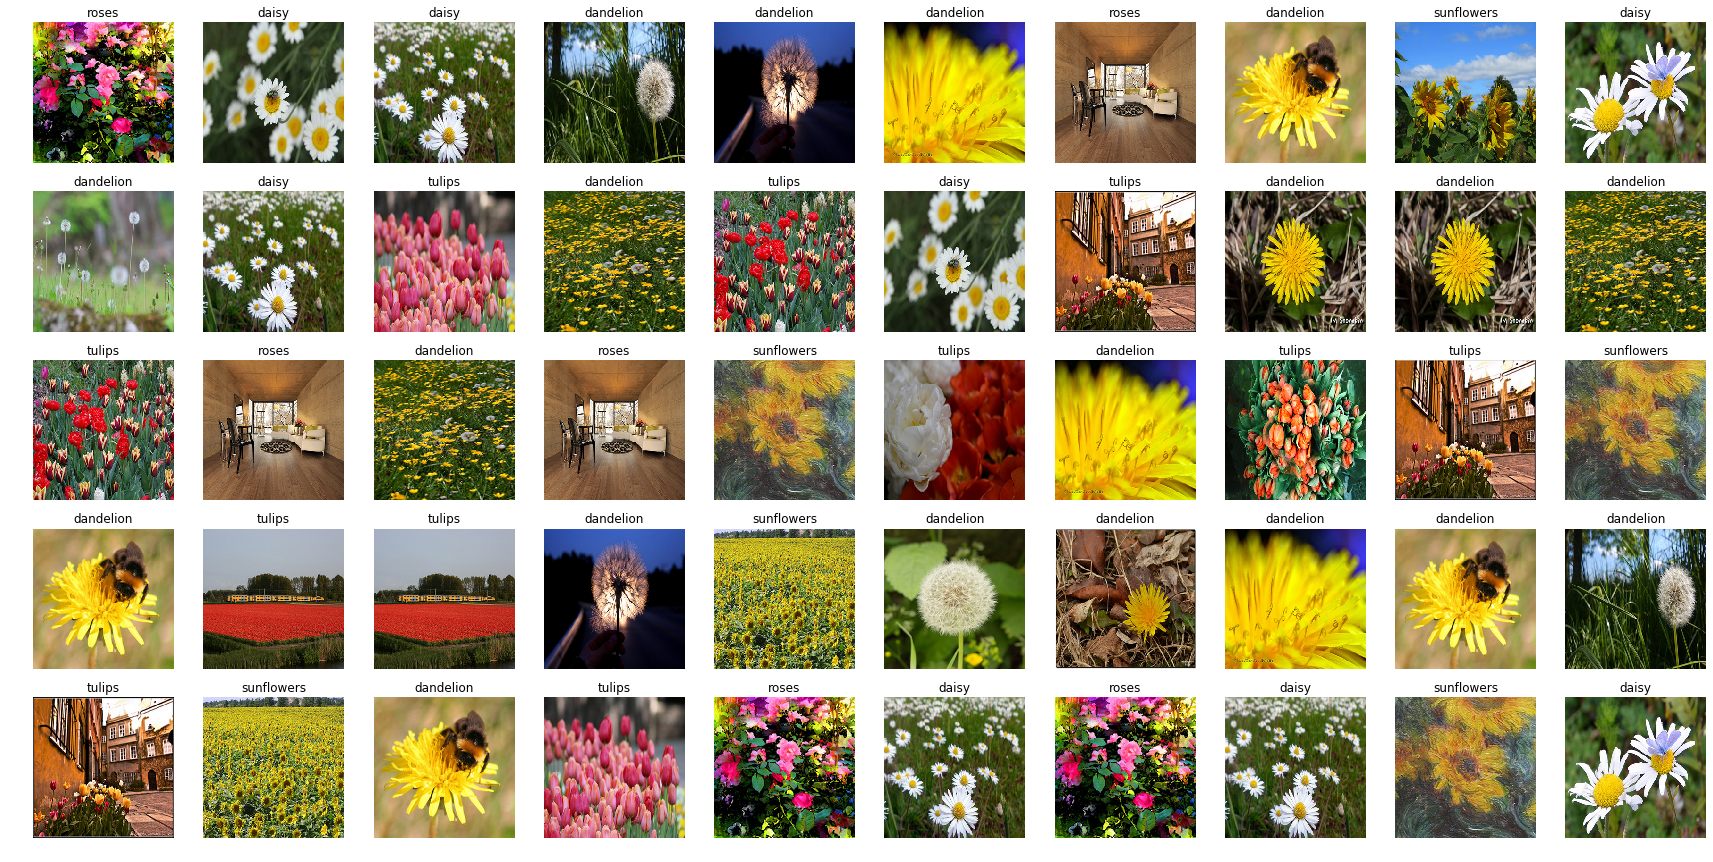

In [7]:
files_queue = tf.train.string_input_producer(["./TFTest/test.tf"])
reader = tf.TFRecordReader()
_,serialized_example = reader.read(files_queue)

feature = {
    'data':tf.FixedLenFeature([],tf.string),
    'h':tf.FixedLenFeature([],tf.int64),
    'w':tf.FixedLenFeature([],tf.int64),
    'c':tf.FixedLenFeature([],tf.int64),
    'name':tf.FixedLenFeature([],tf.string),
}

feature_tensor = tf.parse_single_example(serialized_example,feature)
image_data = tf.decode_raw(feature_tensor['data'],tf.uint8)
image_weight = feature_tensor['w']
image_height = feature_tensor['h']
image_channel = feature_tensor['c']
image_name = feature_tensor['name']
image_data = tf.reshape(image_data, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
BATCH_SIZE = 10

batch_data_t,batch_w_t,batch_h_t,batch_c_t,batch_name_t = tf.train.shuffle_batch([image_data,image_weight,image_height,image_channel,image_name],batch_size=BATCH_SIZE, capacity=1000,min_after_dequeue=10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord,sess=sess)
    plt.figure(figsize=(30,15))
    plt.axis("off")
    for i in range(5):
        batch_data,batch_w,batch_h,batch_c,batch_name = sess.run([batch_data_t,batch_w_t,batch_h_t,batch_c_t,batch_name_t])
        for j in range(BATCH_SIZE):
            shape = batch_data[j].shape
            ax = plt.subplot(5,10,(i*BATCH_SIZE+j)+1)
            ax.axis("off")
            ax.set_title(batch_name[j].decode("utf-8"))
            ax.imshow(batch_data[j])
    plt.show()
    coord.request_stop()
    coord.join()